<a href="https://colab.research.google.com/github/sriram4462/Natural-language-Processing/blob/main/NLP_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import hstack, csr_matrix
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Colab file upload
from google.colab import files

warnings.filterwarnings("ignore")
RANDOM_STATE = 42


1.Upload .TSV files

In [3]:
print("Upload your .TSV files (train.tsv, trial.tsv, test.tsv if available).")
uploaded = files.upload()

for fn in uploaded:
    print("Uploaded:", fn)

Upload your .TSV files (train.tsv, trial.tsv, test.tsv if available).


Saving lcp_single_train.tsv to lcp_single_train.tsv
Uploaded: lcp_single_train.tsv


2.Detect columns (sentence, target, label)

In [7]:
col_sentence_candidates = ["sentence", "text", "context", "sentence_context"]
col_target_candidates   = ["target_word", "target", "token", "word", "target_token"]
col_label_candidates    = ["complexity", "label", "score", "gold"]

def pick_column(candidates, columns):
    for c in candidates:
        if c in columns:
            return c
    return None

COL_SENT = pick_column(col_sentence_candidates, df.columns)
COL_TGT  = pick_column(col_target_candidates,   df.columns)
COL_Y    = pick_column(col_label_candidates,    df.columns)

print("Detected columns:")
print("  Sentence:", COL_SENT)
print("  Target  :", COL_TGT)
print("  Label   :", COL_Y)

if COL_SENT is None or COL_TGT is None or COL_Y is None:
    raise ValueError("Could not detect required columns. Check TSV header names.")


Detected columns:
  Sentence: sentence
  Target  : token
  Label   : complexity


3.Preprocessing & feature frame

In [8]:


def clean_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s

def syllable_count(word: str) -> int:
    """Simple heuristic syllable counter."""
    w = re.sub(r"[^a-zA-Z]", "", str(word)).lower()
    if not w:
        return 0
    groups = re.findall(r"[aeiouy]+", w)
    cnt = len(groups)
    if w.endswith("e"):
        cnt = max(1, cnt - 1)
    return max(1, cnt)

# Build working frame
work = df[[COL_SENT, COL_TGT, COL_Y]].copy()
work[COL_SENT] = work[COL_SENT].astype(str).apply(clean_text)
work[COL_TGT]  = work[COL_TGT].astype(str).apply(clean_text)
work[COL_Y]    = work[COL_Y].astype(float)

# Combined text: sentence + marker + target word
work["input_text"] = work[COL_SENT] + " [TARGET] " + work[COL_TGT]

# Simple numeric features
work["target_len"]       = work[COL_TGT].apply(len)
work["target_syllables"] = work[COL_TGT].apply(syllable_count)

# Drop rows with missing values
work = work.dropna(subset=[COL_SENT, COL_TGT, COL_Y]).reset_index(drop=True)

print("Rows after cleaning:", len(work))
work.head()


Rows after cleaning: 7232


,sentence,token,complexity,input_text,target_len,target_syllables
0,"Behold, there came up out of the river seven c...",river,0.000000,"Behold, there came up out of the river seven c...",5,2
1,I am a fellow bondservant with you and with yo...,brothers,0.000000,I am a fellow bondservant with you and with yo...,8,2
2,"The man, the lord of the land, said to us, 'By...",brothers,0.050000,"The man, the lord of the land, said to us, 'By...",8,2
3,Shimei had sixteen sons and six daughters; but...,brothers,0.150000,Shimei had sixteen sons and six daughters; but...,8,2
4,He has put my brothers far from me. brothers 0...,sons,0.055556,He has put my brothers far from me. brothers 0...,4,1


4.Train/validation split (80/20)

In [9]:


idx_all = np.arange(len(work))
train_idx, val_idx = train_test_split(
    idx_all, test_size=0.2, random_state=RANDOM_STATE
)

X_text_train = work.loc[train_idx, "input_text"]
X_text_val   = work.loc[val_idx,   "input_text"]
y_train      = work.loc[train_idx, COL_Y].values
y_val        = work.loc[val_idx,   COL_Y].values

print(f"Train size: {len(train_idx)} | Val size: {len(val_idx)}")


Train size: 5785 | Val size: 1447


5.TF-IDF features

In [10]:


tfidf_sent = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    stop_words="english"
)
tfidf_tgt = TfidfVectorizer(
    max_features=800,
    ngram_range=(1, 2)
)

# Fit only on training data
tfidf_sent.fit(X_text_train)
tfidf_tgt.fit(work.loc[train_idx, COL_TGT])

X_train_sent = tfidf_sent.transform(X_text_train)
X_val_sent   = tfidf_sent.transform(X_text_val)

X_train_tgt  = tfidf_tgt.transform(work.loc[train_idx, COL_TGT])
X_val_tgt    = tfidf_tgt.transform(work.loc[val_idx,   COL_TGT])

# Numeric features
num_train = np.vstack([
    work.loc[train_idx, "target_len"].values,
    work.loc[train_idx, "target_syllables"].values
]).T
num_val = np.vstack([
    work.loc[val_idx, "target_len"].values,
    work.loc[val_idx, "target_syllables"].values
]).T

X_train_all = hstack([X_train_sent, X_train_tgt, csr_matrix(num_train)])
X_val_all   = hstack([X_val_sent,   X_val_tgt,   csr_matrix(num_val)])

print("Feature shapes:")
print("  Train:", X_train_all.shape)
print("  Val  :", X_val_all.shape)


Feature shapes:
  Train: (5785, 8802)
  Val  : (1447, 8802)


6.Helper functions (RMSE + evaluate)

In [11]:


def rmse_compat(y_true, y_pred):
    """Compute RMSE, works on older/newer sklearn versions."""
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(model, X_tr, y_tr, X_v, y_v, name="model"):
    """Fit model and print RMSE + Pearson correlation."""
    model.fit(X_tr, y_tr)
    preds = model.predict(X_v)
    rmse = rmse_compat(y_v, preds)
    corr = pearsonr(y_v, preds)[0]
    print(f"[{name}] RMSE = {rmse:.4f} | Pearson = {corr:.4f}")
    return preds, rmse, corr


7.Train the  models

In [12]:


#Linear Regression (baseline)
lin = LinearRegression()
pred_lin, rmse_lin, r_lin = evaluate_model(
    lin, X_train_all, y_train, X_val_all, y_val, "Linear Regression"
)

#Ridge Regression (L2-regularised)
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
pred_rdg, rmse_rdg, r_rdg = evaluate_model(
    ridge, X_train_all, y_train, X_val_all, y_val, "Ridge Regression"
)

#Random Forest (on SVD-reduced features for speed)
svd_rf = TruncatedSVD(n_components=200, random_state=RANDOM_STATE)
X_train_red = svd_rf.fit_transform(X_train_all)
X_val_red   = svd_rf.transform(X_val_all)

rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=None,
    max_features="sqrt",
    min_samples_split=2,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
pred_rf, rmse_rf, r_rf = evaluate_model(
    rf, X_train_red, y_train, X_val_red, y_val, "Random Forest (SVD-200)"
)

# SVR (RBF) in latent space (SVD + scaling + SVR)
svr_pipe = Pipeline([
    ("svd",    TruncatedSVD(n_components=300, random_state=RANDOM_STATE)),
    ("scaler", StandardScaler()),
    ("svr",    SVR(kernel="rbf", C=10, gamma="scale")),
])
pred_svr, rmse_svr, r_svr = evaluate_model(
    svr_pipe, X_train_all, y_train, X_val_all, y_val, "SVR (SVD + RBF)"
)


[Linear Regression] RMSE = 0.2728 | Pearson = 0.2132
[Ridge Regression] RMSE = 0.1159 | Pearson = 0.5308
[Random Forest (SVD-200)] RMSE = 0.1202 | Pearson = 0.5183
[SVR (SVD + RBF)] RMSE = 0.1301 | Pearson = 0.3964


8.Collect results in a DataFrame

In [13]:


results = pd.DataFrame([
    {"model": "Linear Regression", "rmse": rmse_lin, "pearson": r_lin},
    {"model": "Ridge Regression",  "rmse": rmse_rdg, "pearson": r_rdg},
    {"model": "Random Forest",     "rmse": rmse_rf,  "pearson": r_rf},
    {"model": "SVR (RBF)",         "rmse": rmse_svr, "pearson": r_svr},
]).sort_values("rmse").reset_index(drop=True)

print("\n=== Final Results (sorted by RMSE) ===")
print(results)



=== Final Results (sorted by RMSE) ===
               model      rmse   pearson
0   Ridge Regression  0.115935  0.530840
1      Random Forest  0.120183  0.518263
2          SVR (RBF)  0.130069  0.396392
3  Linear Regression  0.272769  0.213178


9.Bar chart RMSE & Pearson

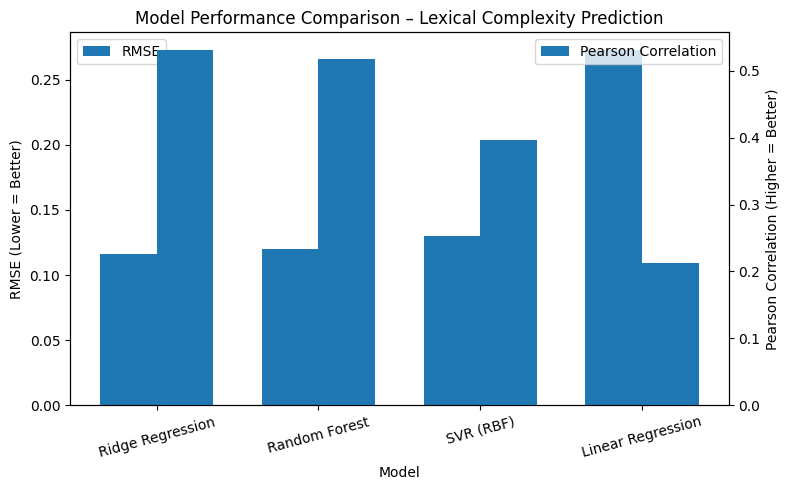

In [14]:


models       = results["model"].tolist()
rmse_vals    = results["rmse"].tolist()
pearson_vals = results["pearson"].tolist()

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 5))

# RMSE bars
ax1.bar(x - width / 2, rmse_vals, width, label="RMSE")
ax1.set_ylabel("RMSE (Lower = Better)")
ax1.set_xlabel("Model")
ax1.set_title("Model Performance Comparison – Lexical Complexity Prediction")
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15)
ax1.legend(loc="upper left")

# Pearson bars on second axis
ax2 = ax1.twinx()
ax2.bar(x + width / 2, pearson_vals, width, label="Pearson Correlation")
ax2.set_ylabel("Pearson Correlation (Higher = Better)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


10.Scatter plot_predicted vs true (Ridge)

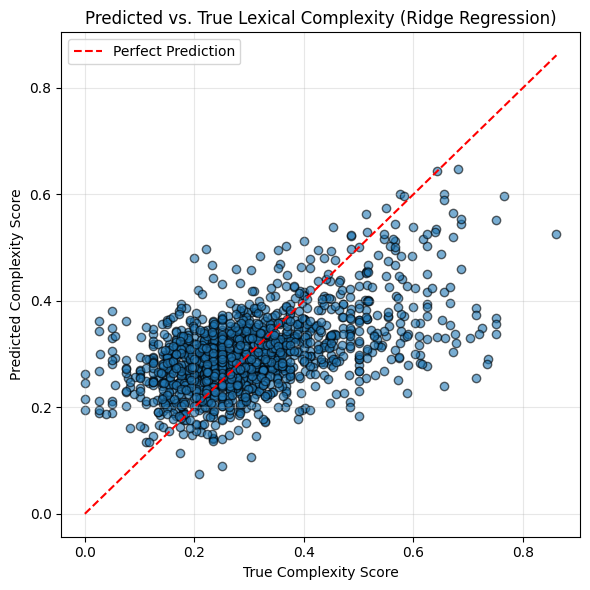

In [15]:


plt.figure(figsize=(6, 6))
plt.scatter(y_val, pred_rdg, alpha=0.6, edgecolors="k")
plt.plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    "r--",
    label="Perfect Prediction"
)
plt.xlabel("True Complexity Score")
plt.ylabel("Predicted Complexity Score")
plt.title("Predicted vs. True Lexical Complexity (Ridge Regression)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
